# Autophagy multi-class classifier (Case 1.5)

<b> What is our goal now? <b>

The main goal is to develop a model that has meaningful uncertainty, meaning the uncertainty is low for known and biologically uninteresting classes, but high for unknown and ideally biologically interesting classes.
The way to test this for the multi-class classifier is by leaving out different biological conditions during training and then checking uncertainty on them.

<b> What are we doing in this section? <b>

1. Read in and briefly investigate the new data
2. Rotate train and test data groups while checking the uncertainty
3. Turn binary clasifier into a multi-class classifier by doing the following:
* modify model output layer to e.g. softmax from sigmoid
* use Cross Entropy loss (as already done actually...)
* update ground truth labels to represent the class indices instead of binary values
* Update evaluation metrics and data loader and specificy number of classes as variable


<b> What is our goal now? <b>

The main goal is to develop a model that has meaningful uncertainty, meaning the uncertainty is low for known and biologically uninteresting classes, but high for unknown and ideally biologically interesting classes. Our hope would be that this new model learns something the original classifier (autophagy_2_1 from SPACRSpy) did not, thereby identifying something new.
The way to test this for the multi-class classifier is by leaving out different biological conditions during training and then checking uncertainty on them as well as by evaluate the new model with screening data, plotting its 8th layer in UMAP and investigating the classifcation scores between the old and new models.

<b> What are we doing in this section? <b>

1. Read in and briefly investigate the new data
2. Rotate train and test data groups while checking the uncertainty
3. Turn binary clasifier into a multi-class classifier by doing the following:
* modify model output layer to e.g. softmax from sigmoid
* use Cross Entropy loss (as already done actually...)
* update ground truth labels to represent the class indices instead of binary values
* potentially update evaluation metrics and data loader and specificy number of classes as variable

4. Evaluate model with screening data in the confusion matrix and plot 8th layer in UMAP
5. Plot and compare classification scores between old autophagy_2_1 model and new multiclass model


<b> What data do we have now? <b>

We now have image data on:
1. Stimulated 14h (or 16h)
2. Unstimulated
3. ATG5 KO (stimulated but that doesn’t matter, this KO supersedes the stim status [probably looks like unstimulated data])
4. Stimulated timecourse data
5. EI24 KO timecourse data

We can think of timeseries as follows: 1h unstim -> more and more vesicle formation -> 15h stimulated. Btw, EI24 (EI24 Autophagy Associated Transmembrane Protein) is a gene which induces apoptosis. 

Data can be found here:

* (1. - 4.) has already been loaded and used before
* Screen single cell images from 6 different slides are here: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/
* Three replicates of single cell image EI24 KO timecourse data are now in /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix

Description of the EI24KO HDF5 files:

These files contain information about cells recorded at different timepoints, however the cells are fixed at each timepoint so we don’t have single cell information across timepoints. For the EI24 KO the last timepoint would be most relevant.

-> Keys: <KeysViewHDF5 ['label_names', 'single_cell_data', 'single_cell_index', 'single_cell_index_labelled']>

* label_names describes the columns of single_cell_index_labelled
* single_cell_data contains the single cell images with the same five channels as always
* single_cell_index two column table of indexed cell ids.
* single_cell_index_labelled information about each cell [b'index', b'cellid', b'ID', b'location', b'timepoint', b'well', b'region', b'Genotype', b'Condition']

## Notebook overview

* [I. Read in new data and create data object HDF5SingleCellDataset](#vis)
* [II. Train multi-class classifier and monitor performance with wandb](#multi)   
* [III. Binary VGG-like classifier from SPARCSpy -> multi-class classifier with same architecture](#multiclass)
* [IV. Evaluate model with screening data in the confusion matrix and plot 8th layer in UMAP](#eval)
* [V. Calculate Classification scores for a) MultiClassClassifier and b) Original autophagy_classifier_2_1 for comparison](#scores)

## I Read in new data and create data object HDF5SingleCellDataset  <a class="anchor" id="vis"></a>

In [1]:
import h5py
import matplotlib.pyplot as plt

num_channels = 5

channel_info = {
    1: "mask nucleus",
    2: "mask cytosol",
    3: "img nucleus",
    4: "img membrane",
    5: "img LC3"
}

In [2]:
#stimulates timeseries 6 slides
stim_timeseries_hdf5_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5"
stim_timeseries_hdf5 = h5py.File(stim_timeseries_hdf5_path, "r")
stim_timeseries_hdf5.keys()

<KeysViewHDF5 ['single_cell_data', 'single_cell_index']>

In [8]:
stim_imeseries_index_hdf5 = stim_timeseries_hdf5["single_cell_index"][:]
stim_timeseries_cells_hdf5 = stim_timeseries_hdf5["single_cell_data"][0:100, :]

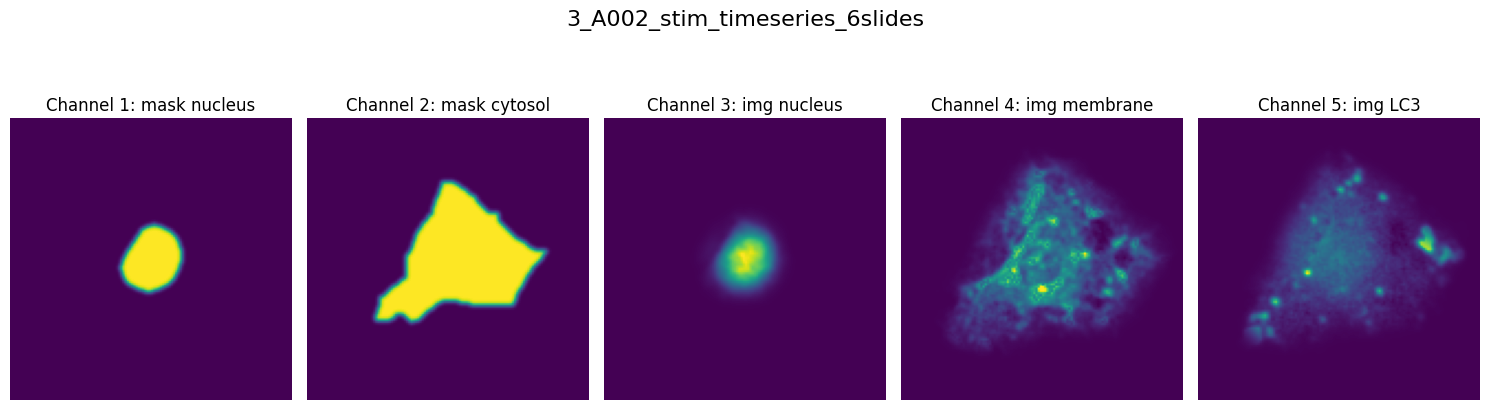

In [9]:
fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))

# Loop through each channel and plot the image in the corresponding subplot
for channel in range(num_channels):
    axes[channel].imshow(stim_timeseries_cells_hdf5[0][channel])
    axes[channel].set_title(f"Channel {channel+1}: {channel_info[channel+1]}")
    axes[channel].axis('off')
plt.tight_layout()

main_title = "3_A002_stim_timeseries_6slides"
plt.suptitle(main_title, fontsize=16, y=1.)
plt.show()

In [5]:
# El24 KO timecourse
El24_KO_hdf5_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/single_cells.h5"
El24_KO_hdf5 = h5py.File(El24_KO_hdf5_path, "r")
El24_KO_hdf5.keys()

<KeysViewHDF5 ['label_names', 'single_cell_data', 'single_cell_index', 'single_cell_index_labelled']>

In [6]:
El24_KO_timeseries_index_hdf5 = El24_KO_hdf5["single_cell_index"][:]
El24_KO_timeseries_cells_hdf5 = El24_KO_hdf5["single_cell_data"][0:100, :]

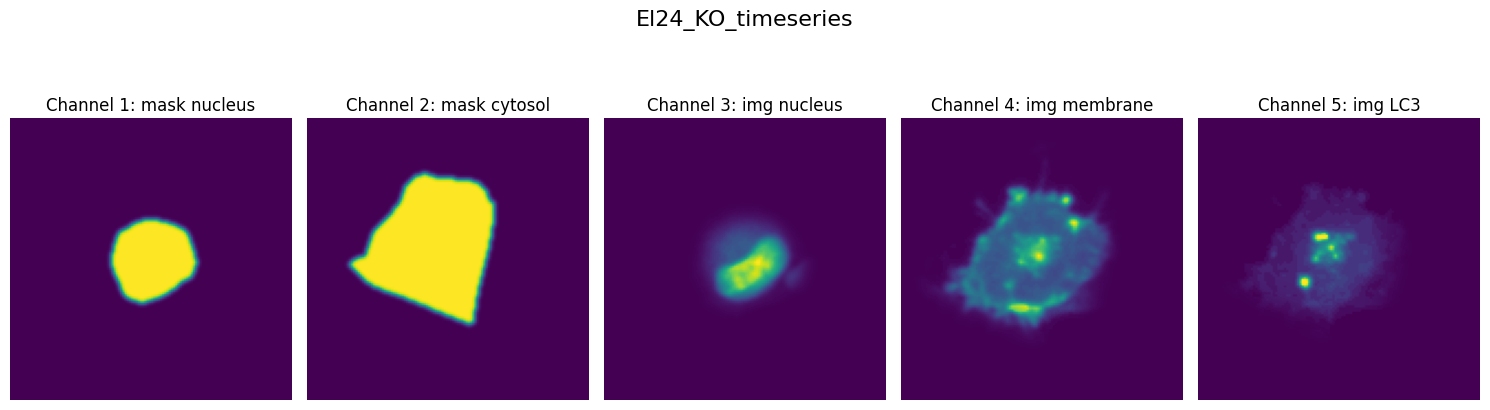

In [7]:
# Create a figure with subplots for each channel
fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))

# Loop through each channel and plot the image in the corresponding subplot
for channel in range(num_channels):
    axes[channel].imshow(El24_KO_timeseries_cells_hdf5[0][channel])
    axes[channel].set_title(f"Channel {channel+1}: {channel_info[channel+1]}")
    axes[channel].axis('off')
plt.tight_layout()
main_title = "El24_KO_timeseries"
plt.suptitle(main_title, fontsize=16, y=1.)
plt.show()

## II.  Train multi-class classifier and monitor performance with wandb <a class="anchor" id="multi"></a>

In [1]:
!pip install torch-intermediate-layer-getter
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for torch-intermediate-layer-getter: filename=torch_intermediate_layer_getter-0.1.post1-py3-none-any.whl size=3724 sha256=02b2068345b059fba015788c06cc9d71840f8f88ea3c9d5297a1cbe9476a517f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2v4eq1xg/wheels/6a/11/c0/30d81aa26172d10d68ffaf352b0762eb9fe0a5f5dcf3de63e0
Successfully built torch-intermediate-layer-getter
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 90 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 3.9 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86854 sha256=df1208b4f2ac250cc22861f31c679630eba1ef73854023d4e152bf3c62e8e913
  Stored in directory: /tmp/pip-ephem-wheel-cache-yoqvrl05/wheels/3a/70/07/428d2b58660a1

In [1]:
import os
import wandb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
import pandas as pd
import torch
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score
import sys
import seaborn as sn
from torch.utils.tensorboard import SummaryWriter
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
import umap
import scanpy as sc
import anndata as ad

from sparcscore.ml.datasets import HDF5SingleCellDataset
#from sparcscore.pipeline.project import TimecourseProject, Project
#from sparcscore.pipeline.workflows import MultithreadedWGATimecourseSegmentation, WGATimecourseSegmentation, MultithreadedCytosolCellposeTimecourseSegmentation, ShardedWGASegmentation, ShardedDAPISegmentationCellpose, WGASegmentation, DAPISegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction, TimecourseHDF5CellExtraction
from sparcscore.pipeline.classification import MLClusterClassifier
from sparcscore.ml.pretrained_models import autophagy_classifier2_1

NOTE! Installing ujson may make loading annotations faster.


## III.  Binary VGG-like classifier from SPARCSpy -> multi-class classifier with same architecture <a class="anchor" id="multiclass"></a>

In [3]:
class MultiClassClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassClassifier, self).__init__()
        
        # VGG-like feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier head for multi-class
        self.fc_input_size = 8192  # size of x matched 
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_size, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes) 
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        
        # Print the size of x to confirm it's correct
        #print("Size of x:", x.size())
        
        x = self.classifier(x)
        return x

# Instance of the model
num_classes = 5  
model = MultiClassClassifier(num_classes)
print(model)

MultiClassClassifier(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (

We specifically want the following scenarios:

train | test

* 1,3 | 2 [Case 1]
* 1,3 | 4 [Case 2]
* 1,3 | 5 [Case 3]
* 1,2,3 | 4 [Case 4]
* 1,2,3 | 5 [Case 5]
* 1,2,3,4 | 5 (advantage is that 4 and 5 have a batch effect vs the others that can be learned by including 4. use only final timepoint of 4?) [Case 6]

We focus on Case 1.5 here.

Note: 1,2 and 3 are the biological classes we had in the first Autophagy (Case 1) notebook.

We set labels as follows in our following hdf5 data objects: 

* Stimulated 14h (or 16h) -> (1)
* Unstimulated -> (2)
* ATG5 KO -> (3)
* Stimulated timecourse -> (4)
* EI24 KO timecourse data -> (5)

### Case 1.5 (use 2,3 for training, and 1 for testing)

In [3]:
case1_hdf5_train_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',  
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5'],
    dir_labels=[2, 2, 2, 2, 1], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 500000
1: 100000
2: 400000


In [4]:
case1_hdf5_test_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_Cr203_filtered.h5',
             ],
    dir_labels=[0, 0, 0, 0, 0, 1, 2], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 700000
0: 500000
1: 100000
2: 100000


### Run multi-class classifier on case 1.5

In [5]:
# Redirect print statements to a file
sys.stdout = open("autophagy_multi_class_output.txt", "w")

# Log into W&B
wandb.login()

# Start a W&B Run
run = wandb.init(project="VGG2_autophagy_multi_class_training")

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the Multi-Class Classifier model on the selected device
num_classes = 3
model = MultiClassClassifier(num_classes)
model.to(device)

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # number of training epochs
batch_size = 256  # batch size
log_interval = 50  # Log metrics every 50 batches

# Set train and test data based on the scenario
train_data = case1_hdf5_train_data
test_data = case1_hdf5_test_data

# Create DataLoaders
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

stop_training = False

for epoch in range(1, num_epochs + 1):
    if stop_training:
        break  # Stop training if accuracy reaches 98.0%

    print("Epoch: ", epoch)
    model.train()  # Set the model to training mode

    total_loss = 0.0
    correct = 0

    total_samples = len(train_data)

    batch_counter = 0  # Reset batch counter at the start of each epoch

    for batch_idx, (data, labels) in enumerate(train_data_loader):
        print("Current batch: " + str(batch_idx))
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradient buffers
        output = model(data)  # Forward pass
        loss = loss_function(output, labels)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.sum().item()
        _, predicted = output.max(1)
        correct += predicted.eq(labels).sum().item()

        batch_counter += 1

        # Calculate accuracy and average loss for the current batch
        accuracy = 100.0 * correct / (batch_counter * batch_size)
        average_loss = total_loss / (batch_counter * batch_size)

        # Check for the desired accuracy and stop training if reached
        if accuracy >= 98.0:
            stop_training = True
            break

        # Calculate class probabilities
        probs = torch.nn.functional.softmax(output, dim=1)

        # Calculate uncertainties (entropy) for each class
        uncertainties = [-torch.sum(p * torch.log(p)) for p in probs]

        # Store uncertainties for each class
        all_class_uncertainties = []
        for i in range(num_classes):
            class_uncertainty = uncertainties[i].detach().cpu().numpy()
            all_class_uncertainties.append(class_uncertainty)

    # Calculate precision, recall, and F1-score for the entire training dataset at the end of the epoch
    all_train_labels = []
    all_train_predicted = []

    for data, labels in train_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)
        _, predicted = output.max(1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predicted.extend(predicted.cpu().numpy())

    train_precision = precision_score(all_train_labels, all_train_predicted, average='macro')
    train_recall = recall_score(all_train_labels, all_train_predicted, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_predicted, average='macro')

    # Calculate training accuracy
    train_accuracy = accuracy_score(all_train_labels, all_train_predicted) * 100.0

    print("Train Precision: " + str(train_precision) + " Recall: " + str(train_recall) + " F1 score: " + str(train_f1))
    print("Train Accuracy: {:.2f}%".format(train_accuracy))
    
    # Log train metrics for the epoch, including accuracy and loss
    wandb.log({
        "Train Epoch": epoch,
        "Train_Precision": train_precision,
        "Train_Recall": train_recall,
        "Train_F1-score": train_f1,
        "Train_Accuracy": train_accuracy,
        "Train_Loss": average_loss,
    })

    # Reset correct and total_loss at the beginning of each epoch
    correct = 0
    total_loss = 0.0

    # Evaluate the model on the test set after each epoch
    model.eval()
    test_correct = 0
    test_total_samples = len(test_data)
    test_average_loss = 0.0
    test_batch_counter = 0
    all_test_labels = []
    all_test_predicted = []

    for data, labels in test_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)
        _, predicted = output.max(1)
        test_correct += predicted.eq(labels).sum().item()
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predicted.extend(predicted.cpu().numpy())

        loss = loss_function(output, labels)
        test_average_loss += loss.sum().item()
        test_batch_counter += 1

        # Calculate accuracy for the current test batch
        test_accuracy = 100.0 * test_correct / (test_batch_counter * batch_size)

        # Log test metrics for every 100 test batches
        if test_batch_counter % log_interval == 0:
            test_average_loss /= log_interval
            print("Test Accuracy: {:.2f}% Test Loss: {:.4f}".format(test_accuracy, test_average_loss))

            test_precision = precision_score(all_test_labels, all_test_predicted, average='macro')
            test_recall = recall_score(all_test_labels, all_test_predicted, average='macro')
            test_f1 = f1_score(all_test_labels, all_test_predicted, average='macro')

            # Log test metrics for every 100 test batches
            wandb.log({
                "Test Epoch": epoch,
                "Test_Batch": test_batch_counter,
                "Test_Loss": test_average_loss,
                "Test_Accuracy": test_accuracy,
                "Test_Precision": test_precision,
                "Test_Recall": test_recall,
                "Test_F1-score": test_f1,
            })
            test_average_loss = 0.0

    # Calculate precision, recall, and F1-score for the entire test dataset at the end of the epoch
    test_precision = precision_score(all_test_labels, all_test_predicted, average='macro')
    test_recall = recall_score(all_test_labels, all_test_predicted, average='macro')
    test_f1 = f1_score(all_test_labels, all_test_predicted, average='macro')
    
    # Log test metrics for the entire test dataset at the end of the epoch
    wandb.log({
        "Test Epoch": epoch,
        "Test_Precision": test_precision,
        "Test_Recall": test_recall,
        "Test_F1-score": test_f1,
    })

    # Calculate and write class uncertainties for the entire test dataset to a file
    test_class_uncertainties = [[] for _ in range(num_classes)]  # Initialize uncertainties for each class

    for data, labels in test_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)

        # Calculate class probabilities
        probs = torch.nn.functional.softmax(output, dim=1)

        # Calculate uncertainties (entropy) for each class
        uncertainties = [-torch.sum(p * torch.log(p)) for p in probs]

        # Store uncertainties for each class
        for i in range(num_classes):
            class_uncertainty = np.mean(uncertainties[i].detach().cpu().numpy())
            test_class_uncertainties[i].extend([class_uncertainty])

    # Save class uncertainties to a file
    with open(f'class_uncertainties_epoch{epoch}.txt', 'w') as f:
        for i in range(num_classes):
            f.write(f'Class {i} Uncertainty: {np.mean(test_class_uncertainties[i])}\n')

# Save model
torch.save(model.state_dict(), 'multi_class_VGG2_case1.pth')

# Close the W&B run
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marunku (crisprscreen). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Test Epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████
Test_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test_Batch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Test_F1-score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test_Loss,▃▃▃▃▃▃▃▄███████▁▁▁▁▁▁▁▂▇▇▇▇▇▇▇
Test_Precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test_Recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Epoch,▁█
Train_Accuracy,▁█
Train_F1-score,▁█
Train_Loss,█▁


### With dropout at test time

In [ ]:
# Seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Redirect print statements to a file
sys.stdout = open("Case_1_5_multi_class_output.txt", "w")
tensorboard_writer = SummaryWriter('runs/Case_1_5_VGG2_autophagy_multi_class_training')

# Log into W&B
wandb.login()

# Start a W&B Run
run = wandb.init(project="VGG2_autophagy_multi_class_training")

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of model
num_classes = 3
model = MultiClassClassifier(num_classes)
model.to(device)

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5  # number of training epochs
batch_size = 256  # batch size
log_interval = 50  # Log metrics every 50 batches

epsilon = 1e-8  # Small epsilon value to prevent log(0) in uncertainties

# Set train and test data based on the scenario
train_data = case1_hdf5_train_data
test_data = case1_hdf5_test_data

# Create DataLoaders
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

stop_training = False

# Training loop
for epoch in range(1, num_epochs + 1):
    if stop_training:
        break  
    
    print("Epoch: ", epoch)
    model.train()  # Set model to training mode

    total_loss = 0.0
    correct = 0
    total_samples = len(train_data)
    batch_counter = 0  # Reset batch counter at the start of each epoch

    for batch_idx, (data, labels) in enumerate(train_data_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradient buffers
        output = model(data)  # Forward pass
        loss = loss_function(output, labels)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.sum().item()
        _, predicted = output.max(1)
        correct += predicted.eq(labels).sum().item()

        batch_counter += 1
        
        # Calculate accuracy and average loss for the current batch
        accuracy = 100.0 * correct / (batch_counter * batch_size)
        average_loss = total_loss / (batch_counter * batch_size)

        # Check for the desired accuracy and stop training if reached
        if accuracy >= 95.0:
            stop_training = True
            print("Accuracy over 95% reached and thus stopping training...")
            break

    # Calculate and log training metrics
    all_train_labels = []
    all_train_predicted = []

    for data, labels in train_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)
        _, predicted = output.max(1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predicted.extend(predicted.cpu().numpy())

    train_precision = precision_score(all_train_labels, all_train_predicted, average='macro')
    train_recall = recall_score(all_train_labels, all_train_predicted, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_predicted, average='macro')
    train_balanced_accuracy = balanced_accuracy_score(all_train_labels, all_train_predicted)

    train_accuracy = accuracy_score(all_train_labels, all_train_predicted) * 100.0

    print("Train Precision: " + str(train_precision) + " Recall: " + str(train_recall) + " F1 score: " + str(train_f1))
    print("Train Balanced Accuracy: {:.2f}%".format(train_balanced_accuracy))
    
    # Log train metrics for the epoch
    wandb.log({
        "Train Epoch": epoch,
        "Train_Precision": train_precision,
        "Train_Recall": train_recall,
        "Train_F1-score": train_f1,
        "Train_Balanced_Accuracy": train_balanced_accuracy,
        "Train_Loss": average_loss,
    })
    
    # Log on TensorBoard
    tensorboard_writer.add_scalar('Train_Precision', train_precision, global_step=epoch)
    tensorboard_writer.add_scalar('Train_Recall', train_recall, global_step=epoch)
    tensorboard_writer.add_scalar('Train_F1-score', train_f1, global_step=epoch)
    tensorboard_writer.add_scalar('Train_Balanced_Accuracy', train_balanced_accuracy, global_step=epoch)
    tensorboard_writer.add_scalar('Train_Loss', average_loss, global_step=epoch)

    correct = 0
    total_loss = 0.0

    # Test loop with dropout and aggregated confusion matrix
    model.eval()
    
    # Enable dropout during testing
    model.apply(lambda m: setattr(m, 'training', True))

    test_correct = 0
    test_average_loss = 0.0
    all_test_labels = []
    all_test_predicted = []
    test_class_uncertainties = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for data, labels in test_data_loader:
            data = data.to(device)
            labels = labels.to(device)

            output = model(data)
            _, predicted = output.max(1)
            test_correct += predicted.eq(labels).sum().item()
            all_test_labels.extend(labels.cpu().numpy())
            all_test_predicted.extend(predicted.cpu().numpy())

            loss = loss_function(output, labels)
            test_average_loss += loss.sum().item()

            # Calculate class probabilities
            probs = torch.nn.functional.softmax(output, dim=1)

            # Calculate uncertainties (entropy) for each class
            uncertainties = [-torch.sum(p * torch.log(p + epsilon)) for p in probs]

            # Store uncertainties for each class
            for i in range(num_classes):
                class_uncertainty = np.mean(uncertainties[i].detach().cpu().numpy())
                test_class_uncertainties[i].extend([class_uncertainty])

    # Filter out predictions and labels for classes seen during training
    mask_seen_classes = np.isin(all_test_labels, [1, 2])  # Class1 and 2 seen at training
    filtered_test_labels = np.array(all_test_labels)[mask_seen_classes]
    filtered_test_predicted = np.array(all_test_predicted)[mask_seen_classes]
    

    # Calculate accuracy and loss only for the seen classes
    test_accuracy = accuracy_score(filtered_test_labels, filtered_test_predicted)
    test_average_loss = test_average_loss / len(test_data)

    print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
    print("Test Loss: {:.4f}".format(test_average_loss))

    wandb.log({
        "Test_Accuracy": test_accuracy,
        "Test_Loss": test_average_loss,
    })

    tensorboard_writer.add_scalar('Test_Accuracy', test_accuracy, global_step=epoch)
    tensorboard_writer.add_scalar('Test_Loss', test_average_loss, global_step=epoch)
    
    # Aggregate and log confusion matrix
    aggregated_confusion = confusion_matrix(all_test_labels, all_test_predicted)

    # Confusion matrix
    epsilon = 1e-8
    df_cm = pd.DataFrame(aggregated_confusion / (np.sum(aggregated_confusion, axis=1)[:, None] + epsilon),
                         index=[i for i in range(num_classes)],
                         columns=[i for i in range(num_classes)])

    # Save confusion matrix to TensorBoard
    figure = sn.heatmap(df_cm, annot=True).get_figure()
    tensorboard_writer.add_figure(f'Aggregated Confusion Matrix - Epoch {epoch}', figure, global_step=epoch)
    
    # Set the model back to training mode
    model.train()
    
    # Plot histogram of uncertainties
    class1_uncertainties = test_class_uncertainties[0]
    plt.hist(class1_uncertainties, bins=50, alpha=0.5, color='blue', label='Class 0 Uncertainties')
    plt.xlabel('Uncertainty')
    plt.ylabel('Frequency')
    plt.title('Uncertainty Distribution for Class 0')
    plt.legend()
    plt.savefig(f'uncertainty_histogram_class1_epoch{epoch}.png')
    plt.close()

# Save model
print("Saving final model now...")
torch.save(model.state_dict(), 'multi_class_VGG2_case1_5.pth')

# Close the W&B run
wandb.finish()

# Close the TensorBoard writer
tensorboard_writer.close()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marunku (crisprscreen). Use `wandb login --relogin` to force relogin


This code calculates and logs uncertainties for each class by computing the entropy of class probabilities and stores these values in separate logs with class-specific names. This way, we can analyze uncertainties for each class individually.

During testing, it only evaluates accuracy and loss for the classes seen during training.
Dropout is run only 5 times during testing, and uncertainties are stored for each class for each dropout run.
It logs an aggregated confusion matrix for each of the 5 dropout runs

## IV.  Evaluate model with screening data in the confusion matrix and plot 8th layer in UMAP <a class="anchor" id="eval"></a>

We want to include the unlabeled (like class 0 looking) screening data to our current test set to evaluate our fully trained model and plot the confusion matrix. We do not retrain at this point, we want to understand if the model is overfitting or not.

*Reminder*: In a confusion matrix, the rows typically represent the actual classes or ground truth labels, while the columns represent the predicted classes by the model.

In [4]:
case1_hdf5_test_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5'
             ],
    dir_labels=[0, 0, 0, 0, 0, 1, 2, 3], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 1058879
0: 500000
1: 100000
2: 100000
3: 358879


In [5]:
#Load pretrained model
num_classes = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MultiClassClassifier(num_classes)
model.load_state_dict(torch.load('multi_class_VGG2_case1_5.pth'))
model.to(device)

MultiClassClassifier(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (

#### Evaluate with screen data

In [6]:
# Create DataLoader for test_data
batch_size = 256 
test_data_loader = DataLoader(case1_hdf5_test_data, batch_size=batch_size, shuffle=False)

# Initialize TensorBoard writer
tensorboard_writer = SummaryWriter('runs/Case_1_5_VGG2_autophagy_confusion_matrix')

# Test loop
model.eval()
all_test_labels = []
all_test_predicted = []

with torch.no_grad():
    for data, labels in test_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)
        _, predicted = output.max(1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predicted.extend(predicted.cpu().numpy())

# Calculate  confusion matrix
confusion_matrix_result = confusion_matrix(all_test_labels, all_test_predicted)

# Print cm to console
print("Confusion Matrix:")
print(confusion_matrix_result)

# Save confusion matrix to TensorBoard
epsilon = 1e-8
num_classes = 4

class_names = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Screening"]
df_cm = pd.DataFrame(confusion_matrix_result / (confusion_matrix_result.sum(axis=1)[:, None] + epsilon),
                     index=class_names,
                     columns=class_names)

# Set figsize
plt.figure(figsize=(10, 8)) 

# Plot confusion matrix
sn.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# save confusion matrix to TensorBoard
tensorboard_writer.add_figure('Confusion Matrix', plt.gcf())

# save confusion matrix to file
df_cm.to_csv('confusion_matrix_case1_5_with_screendata.csv', index=True)

# Close the TensorBoard writer
tensorboard_writer.close()

Confusion Matrix:
[[     0 148321 351679      0]
 [     0   5184  94816      0]
 [     0    280  99720      0]
 [     0  97746 261133      0]]


#### Plot 8th layer

*Note*: We have to randomely subsample the dataset before plotting the 8th layer activations becuase it keeps crashing the kernals due to dataset being too large for memory (even after trying out different batch sizes, CPU/GPU architectures, number of workers, datasplits, etc.)

In [9]:
# 8th layer activations name from model architecture
layer_name = 'features.24' 

# define the return layers for IntermediateLayerGetter
return_layers = {layer_name: layer_name}

# Initialize the model with correct feature output
mid_getter = MidGetter(model, return_layers=return_layers, keep_output=True)

# Define the size of the subset!!! (not full dataset here due to kernal crahsing!)
subset_size = 7600 

# Create DataLoader
batch_size = 512
test_data_loader = DataLoader(case1_hdf5_test_data, batch_size=batch_size, shuffle=False)

# Randomly sample a subset of the dataset
subset_indices = torch.randperm(len(case1_hdf5_test_data))[:subset_size]
subset_sampler = SubsetRandomSampler(subset_indices)

# Create a new DataLoader for the subset
subset_data_loader = DataLoader(case1_hdf5_test_data, batch_size=batch_size, sampler=subset_sampler)

# Lists to store activations and labels
activations = []
labels = []

# Forward pass of subset through the model to get activations
with torch.no_grad():
    for data, label in tqdm(subset_data_loader, desc="Processing data", leave=False):
        data = data.to(device) 
        mid_outputs, _ = mid_getter(data)
        # Get the activations
        activations.append(mid_outputs[layer_name].cpu().detach().numpy())
        labels.append(label.numpy())

# Concatenate activations and labels from all batches
activations = np.concatenate(activations, axis=0)
labels = np.concatenate(labels, axis=0)

Processing data:   0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
print(labels)

[3 1 0 ... 0 0 0]


In [11]:
print(activations)

[[[[1.53967485e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 1.60307318e-01]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 4.41675276e-01 ... 1.18813300e+00
    1.65347993e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.42855716e-01
    0.00000000e+00 0.00000000e+00]
   [1.48460701e-01 0.00000000e+00 0.00000000e+00 ... 6.07630722e-02
    0.00000000e+00 1.83819756e-01]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 1.59947544e-01 ... 9.66

The activations variable contains the output activations of a specific layer from the  model. These activations represent the feature representations learned by the model in response to the input data. Each row in the activations array corresponds to the activations produced by the model for a particular input sample.

In [18]:
#save activations and labels to files
np.save('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/Case_1_5__activations_layer_8.npy', activations)
np.save('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/Case_1_5_labels_layer_8.npy', labels)

In [6]:
#lload activations and labels from files
activations = np.load('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/Case_1_5__activations_layer_8.npy')
labels = np.load('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/Case_1_5_labels_layer_8.npy')

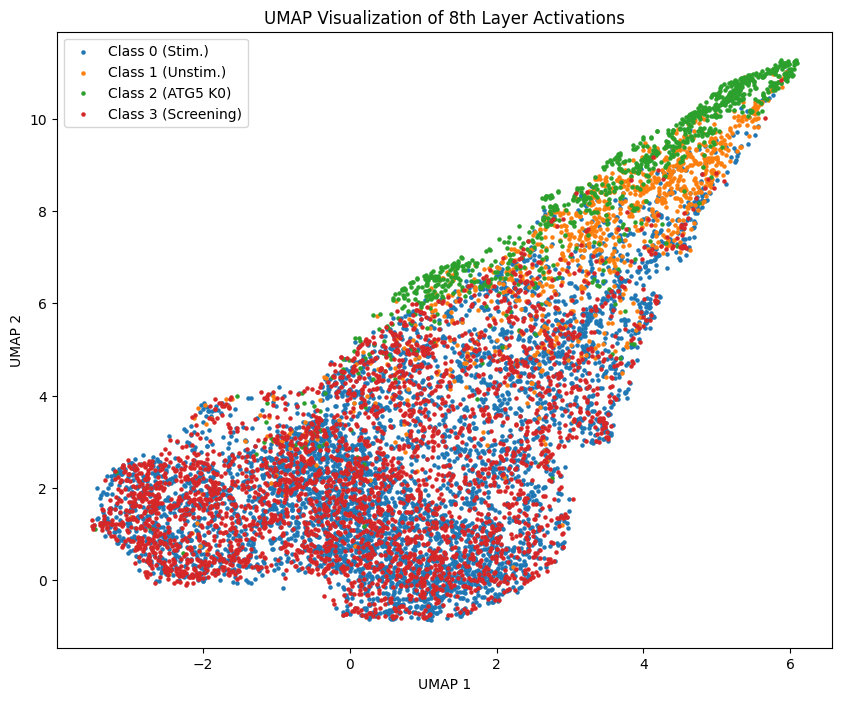

In [6]:
%matplotlib inline

# Reshape activations to 2 dims
activations_flat = activations.reshape(activations.shape[0], -1)

# Calc. UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(activations_flat)

# Define new class labels from 0,1,2,3 to readbale labels
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Screening)"]

# Plot UMAP
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)
plt.legend()
plt.title('UMAP Visualization of 8th Layer Activations')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

We note that screening behaves like class 0 with some overlay but also with some separateness!


Now we try with the same cells as we had for Case 1 using the same indices:

In [2]:
case1_hdf5_test_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
                            '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5'
             ],
    dir_labels=[1,1,2,0,3], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 758879
0: 100000
1: 200000
2: 100000
3: 358879


In [6]:
# 8th layer activations name from model architecture
layer_name = 'features.24' 

# define the return layers for IntermediateLayerGetter
return_layers = {layer_name: layer_name}

# Initialize the model with correct feature output
mid_getter = MidGetter(model, return_layers=return_layers, keep_output=True)

# Define the size of the subset!!! (not full dataset here due to kernal crahsing!)
subset_size = 7600 

# Create DataLoader
batch_size = 512
test_data_loader = DataLoader(case1_hdf5_test_data, batch_size=batch_size, shuffle=False)

# Randomly sample a subset of the dataset
subset_indices = torch.randperm(len(case1_hdf5_test_data))[:subset_size]

# Load the subset indices from the file
subset_indices = torch.load('Case_1_subset_indices.pth')

# Create a new subset sampler with the loaded indices
subset_sampler = SubsetRandomSampler(subset_indices)

# Create a new DataLoader for the subset
subset_data_loader = DataLoader(case1_hdf5_test_data, batch_size=batch_size, sampler=subset_sampler)

# Lists to store activations and labels
activations = []
labels = []

# Forward pass of subset through the model to get activations
with torch.no_grad():
    for data, label in tqdm(subset_data_loader, desc="Processing data", leave=False):
        data = data.to(device) 
        mid_outputs, _ = mid_getter(data)
        # Get the activations
        activations.append(mid_outputs[layer_name].cpu().detach().numpy())
        labels.append(label.numpy())

# Concatenate activations and labels from all batches
activations = np.concatenate(activations, axis=0)
labels = np.concatenate(labels, axis=0)

Processing data:   0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
#save activations and labels to files
np.save('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/Case_1_5_junk___activations_layer_8.npy', activations)
np.save('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/Case_1_5_junk_labels_layer_8.npy', labels)

In [16]:
#lload activations and labels from files
activations = np.load('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/Case_1_5_junk___activations_layer_8.npy')
labels = np.load('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/Case_1_5_junk_labels_layer_8.npy')

In [17]:
%matplotlib inline

# Reshape activations to 2 dims
activations_flat = activations.reshape(activations.shape[0], -1)

# Calc. UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(activations_flat)

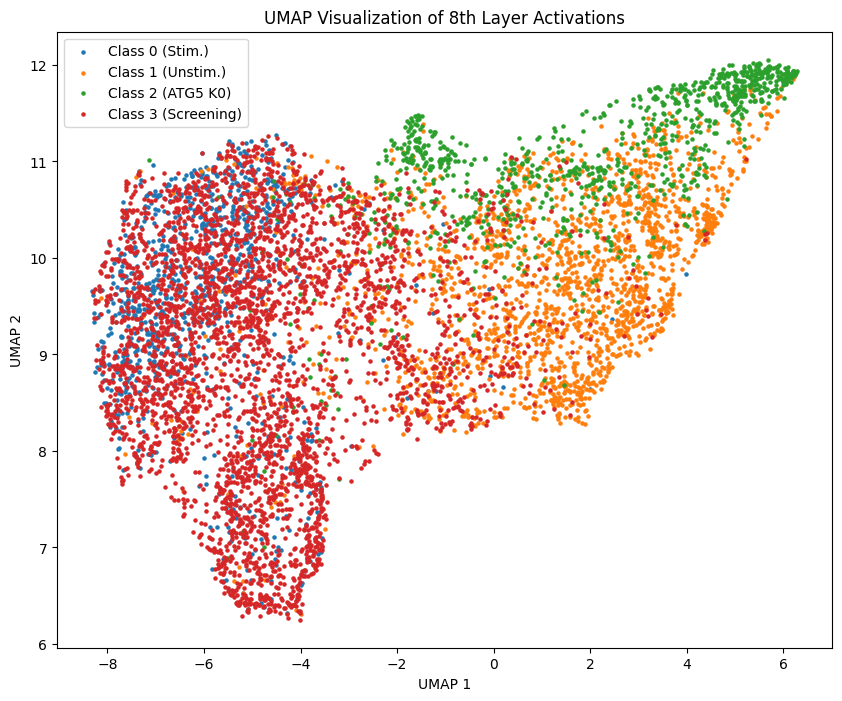

In [28]:
# Define new class labels from 0,1,2,3 to readbale labels
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Screening)"]

# Plot UMAP
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)
plt.legend()
plt.title('UMAP Visualization of 8th Layer Activations')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [14]:
# Create AnnData object
adata = ad.AnnData(X=umap_result)

# Define class labels
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Screening)"]

# Map numerical labels to string labels
label_map = {i: label for i, label in enumerate(class_labels)}

# Add .obs infos
adata.obs['class_labels'] = labels
adata.obs['class_labels'] = adata.obs['class_labels'].map(label_map)


# Run leiden and make UMAP
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

# define a custom discrete colormaps
colors_leiden = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
cmap_leiden = ListedColormap(colors_leiden, name='custom_discrete_cmap_leiden')

colors_class_labels = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
cmap_class_labels = ListedColormap(colors_class_labels, name='custom_discrete_cmap_class_labels')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


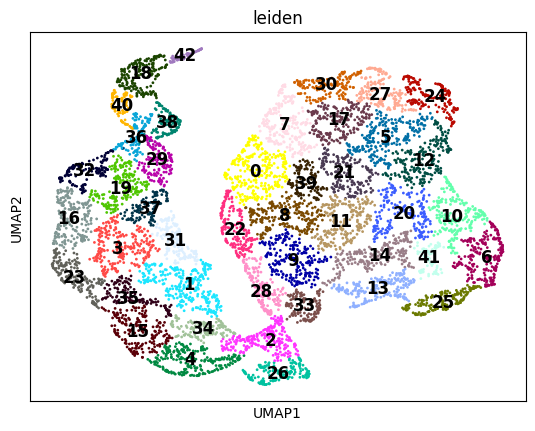

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


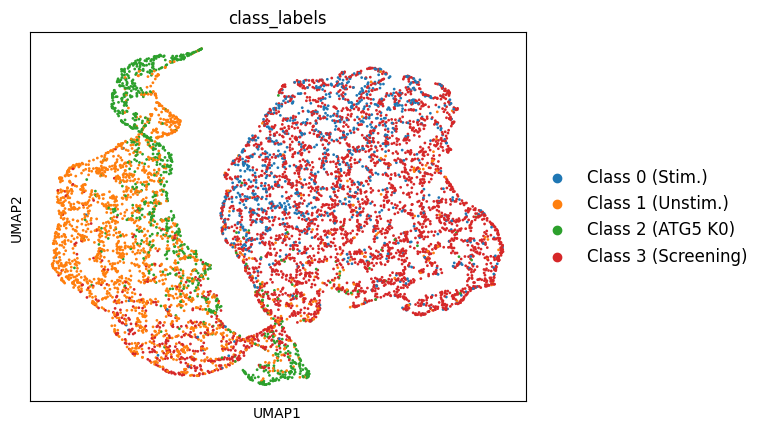

In [15]:
sc.pl.umap(adata, color=['leiden'], cmap=cmap_leiden, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['class_labels'], cmap=cmap_class_labels, legend_loc='right margin', legend_fontsize=12)

In [12]:
# Get the cell IDs of screening class 3 cells from the subset
screening_cells = adata[adata.obs['class_labels'] == 'Class 3 (Screening)'].obs_names
print("Cell IDs of screening class 3 cells:")
print(screening_cells)

Cell IDs of screening class 3 cells:
Index(['0', '2', '4', '6', '7', '11', '13', '17', '19', '20',
       ...
       '7584', '7586', '7587', '7589', '7590', '7592', '7595', '7596', '7597',
       '7598'],
      dtype='object', length=3654)


In [13]:
# Subset adata to include only the selected Leiden clusters
selected_clusters = ["42", "40", "18", "38", "36", "29", "32", "19", "37", "16", "3", "31", "23", "1", "36", "15", "4", "34"]
adata_subset = adata[adata.obs['leiden'].isin(selected_clusters)]

# Get the cell IDs of screening class 3 cells within the subset
screening_indices = adata_subset[adata_subset.obs['class_labels'] == 'Class 3 (Screening)'].obs_names
print("Cell indices of screening class 3 cells within the selected Leiden clusters:")
print(screening_indices)

# Calculate the number of resulting screening indices
num_screening_indices = len(screening_indices)
print("Number of screening indices:", num_screening_indices)

Cell indices of screening class 3 cells within the selected Leiden clusters:
Index(['7', '11', '58', '70', '91', '112', '118', '135', '164', '254',
       ...
       '7358', '7379', '7384', '7405', '7431', '7494', '7529', '7551', '7558',
       '7586'],
      dtype='object', length=352)
Number of screening indices: 352


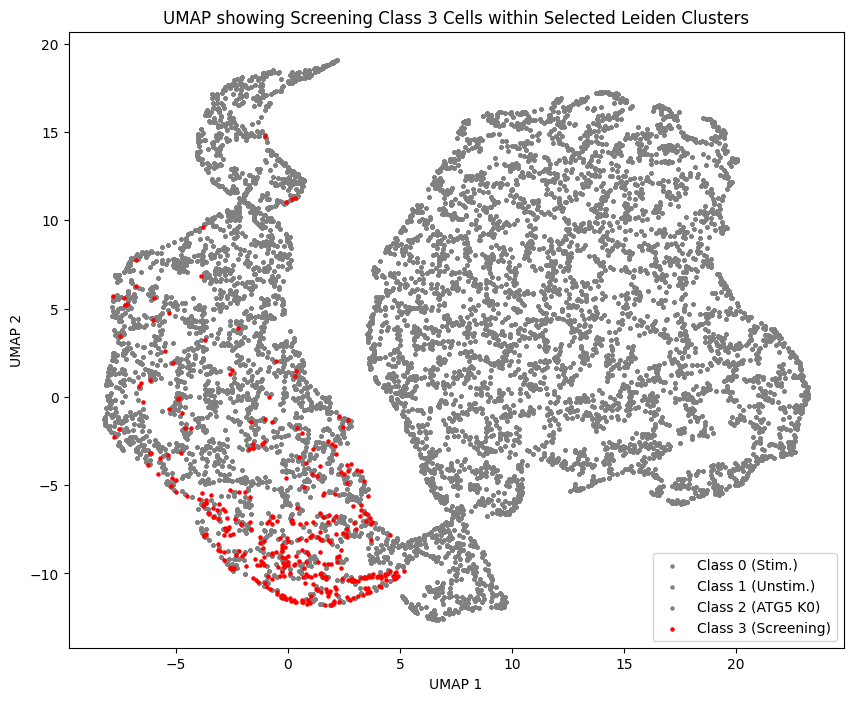

In [20]:
# Define colors for class labels
colors = {'Class 0 (Stim.)': 'grey', 
          'Class 1 (Unstim.)': 'grey', 
          'Class 2 (ATG5 K0)': 'grey', 
          'Class 3 (Screening)': 'red'}

# Create a mask to filter only screening class 3 cells within selected Leiden clusters
mask = (adata.obs['class_labels'] == 'Class 3 (Screening)') & (adata.obs['leiden'].isin(selected_clusters))

# UMAP
plt.figure(figsize=(10, 8))
for label, color in colors.items():
    if label == 'Class 3 (Screening)':
        plt.scatter(adata.obsm['X_umap'][mask, 0], adata.obsm['X_umap'][mask, 1], c=color, label=label, s=5)
    else:
        plt.scatter(adata.obsm['X_umap'][~mask, 0], adata.obsm['X_umap'][~mask, 1], c=color, label=label, s=5)

plt.title('UMAP showing Screening Class 3 Cells within Selected Leiden Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

In [37]:
# Convert both lists to sets
obs_screening_indices = set(screening_indices)
direct_screening_indices = set([
    '241', '338', '426', '492', '498', '505', '703', '733', '880', '915',
    '1177', '1278', '1394', '1495', '1585', '1605', '1776', '1896', '1950',
    '2109', '2185', '2195', '2296', '2342', '2482', '2553', '2599', '2674',
    '3185', '3296', '3552', '3727', '4038', '4432', '4634', '4663', '4718',
    '4720', '4895', '4933', '4956', '4976', '5004', '5051', '5128', '5146',
    '5165', '5166', '5286', '5413', '5609', '5718', '5763', '5782', '5811',
    '5853', '5863', '6079', '6082', '6106', '6176', '6263', '6325', '6340',
    '6405', '6487', '6707', '6774', '6791', '6899', '7089', '7116', '7171',
    '7258'
])

# Check for overlaps
overlaps = obs_screening_indices.intersection(direct_screening_indices)
print("Overlapping screening indices:", overlaps)

Overlapping screening indices: {'1950', '5166', '6707', '5763'}


## V.  Calculate Classification scores for a) MultiClassClassifier and b) Original autophagy_classifier_2_1 for comparison <a class="anchor" id="scores"></a>

#### a) MultiClassClassifier

In [26]:
# Calculate Classification Scores

# Load the subset indices from the file
subset_indices = torch.load('Case_1_subset_indices.pth')

# Create a new subset sampler with the loaded indices
subset_sampler = SubsetRandomSampler(subset_indices)

# Define the size of the subset!!! (not full dataset here due to kernal crahsing!)
subset_size = 7600 

#Set batch size
batch_size = 512

# Create a new DataLoader for the subset
subset_data_loader = DataLoader(case1_hdf5_test_data, batch_size=batch_size, sampler=subset_sampler)

classification_scores = []

with torch.no_grad():
    for data, labels in tqdm(subset_data_loader, desc="Calculating Scores", leave=False):
        data = data.to(device)
        logits = model(data)
        probabilities = torch.softmax(logits, dim=1)
        classification_scores.append(probabilities.cpu().detach().numpy())

# Concatenate classification scores from all batches
classification_scores = np.concatenate(classification_scores, axis=0)
classification_scores

Calculating Scores:   0%|          | 0/15 [00:00<?, ?it/s]

array([[1.2206716e-16, 2.2371104e-02, 9.7762889e-01],
       [0.0000000e+00, 9.9576782e-06, 9.9998999e-01],
       [2.2011351e-12, 5.5681929e-02, 9.4431812e-01],
       ...,
       [1.7992289e-18, 9.7758728e-01, 2.2412723e-02],
       [8.3939907e-05, 3.1406206e-01, 6.8585396e-01],
       [7.6283855e-15, 1.8154556e-02, 9.8184550e-01]], dtype=float32)

In [28]:
# Save classification scores to a file
np.save('Case1_classification_scores.npy', classification_scores)

In [31]:
classification_scores = np.load('Case1_classification_scores.npy')

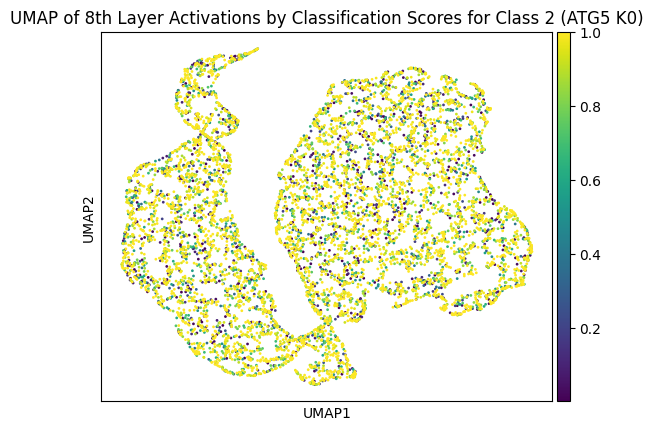

In [29]:
# Determine the class index from the classification scores index
class_index = 2 
class_label = class_labels[class_index]
title = f'UMAP of 8th Layer Activations by Classification Scores for {class_label}'

# Plot in UMAP
adata.obs['classification_scores'] = classification_scores[:, class_index]
sc.pl.umap(adata, color=['classification_scores'], cmap='viridis', legend_loc='right margin', legend_fontsize=12, title=title)

Same plot but now only showing screening Class 3 cells:

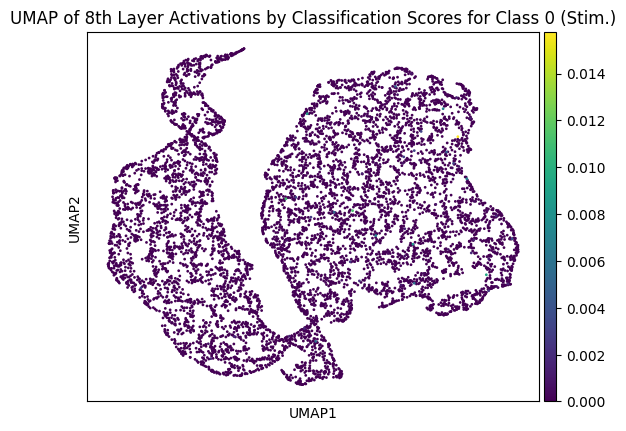

In [34]:
# Determine the class index from the classification scores index
class_index = 0
class_label = class_labels[class_index]
title = f'UMAP of 8th Layer Activations by Classification Scores for {class_label}'

# Create a mask to identify class 3 screening cells
is_class_3_screening = adata.obs['class_labels'] == 'Class 3 (Screening)'

# Create a new array to hold the classification scores for class 3 screening cells
classification_scores_class_3_screening = np.zeros_like(classification_scores[:, class_index])
classification_scores_class_3_screening[is_class_3_screening] = classification_scores[is_class_3_screening, class_index]

# Plot in UMAP
adata.obs['classification_scores_class_3_screening'] = classification_scores_class_3_screening
sc.pl.umap(adata, color=['classification_scores_class_3_screening'], cmap='viridis', legend_loc='right margin', legend_fontsize=12, title=title)


#### b) autophagy_2_1

In [6]:
#Load pretrained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = autophagy_classifier2_1(device)
model.eval()
model

cuda


Lightning automatically upgraded your loaded checkpoint from v1.5.5 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../workspace/SPARCSpy/src/pretrained_models/autophagy/autophagy2.1/VGG2_autophagy_classifier2.1.cpkt`


MultilabelSupervisedModel(
  (network): _VGG2(
    (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (softmax): LogSoftmax(dim=1)
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, k

In [7]:
# Calculate Classification Scores

# Load the subset indices from the file
subset_indices = torch.load('Case_1_subset_indices.pth')

# Create a new subset sampler with the loaded indices
subset_sampler = SubsetRandomSampler(subset_indices)

# Define the size of the subset!!! (not full dataset here due to kernal crahsing!)
subset_size = 7600 

#Set batch size
batch_size = 512

# Create a new DataLoader for the subset
subset_data_loader = DataLoader(case1_hdf5_test_data, batch_size=batch_size, sampler=subset_sampler)

classification_scores = []

with torch.no_grad():
    for data, labels in tqdm(subset_data_loader, desc="Calculating Scores", leave=False):
        data = data.to(device)
        logits = model(data)
        probabilities = torch.softmax(logits, dim=1)
        classification_scores.append(probabilities.cpu().detach().numpy())

# Concatenate classification scores from all batches
classification_scores = np.concatenate(classification_scores, axis=0)
classification_scores

Calculating Scores:   0%|          | 0/15 [00:00<?, ?it/s]

array([[9.9993885e-01, 6.1097518e-05],
       [9.9542612e-01, 4.5738858e-03],
       [1.9168303e-07, 9.9999976e-01],
       ...,
       [9.9999428e-01, 5.6957383e-06],
       [9.9994242e-01, 5.7573310e-05],
       [9.9999857e-01, 1.3919145e-06]], dtype=float32)

In [8]:
# Save classification scores to a file
np.save('Case1_5_original_autophagy_2_1_classification_scores.npy', classification_scores)

In [23]:
classification_scores = np.load('Case1_5_original_autophagy_2_1_classification_scores.npy')

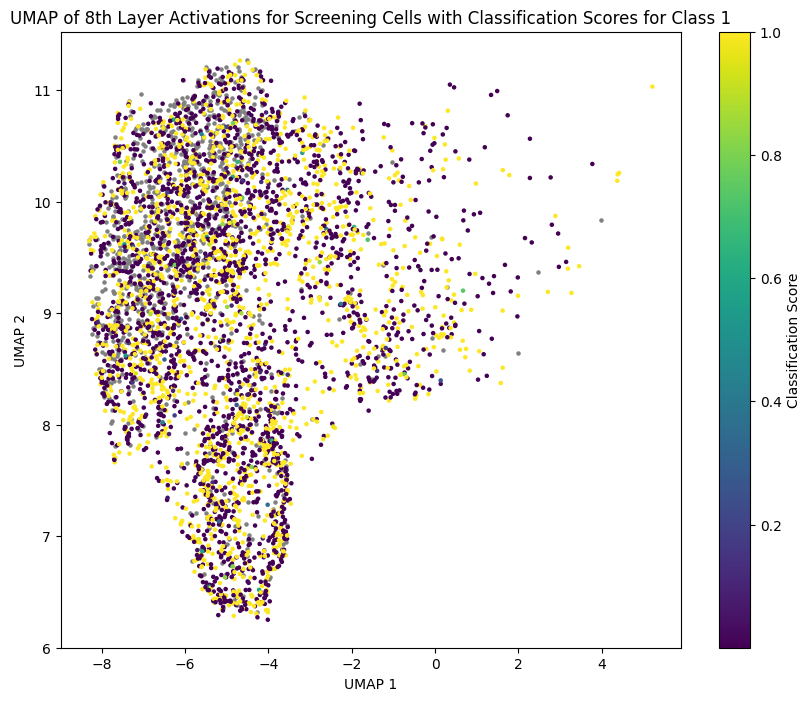

In [26]:
class_index = 1
class_labels = ["Class 0", "Class 1"]
plt.figure(figsize=(10, 8))

# Plot cells belonging to class 3 (screening) with color based on classification score
for i, label in enumerate(class_labels[:-1]):  # Exclude the last class (screening)
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

# Color the screening cells based on their classification score
cmap = plt.get_cmap('viridis')
screening_scores = classification_scores[screening_idx]
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], c=screening_scores[:, class_index], cmap=cmap, label='Screening Cells', s=5)
cbar = plt.colorbar()
cbar.set_label('Classification Score')

  
class_label = class_labels[class_index]
title = f'UMAP of 8th Layer Activations for Screening Cells with Classification Scores for {class_label}'

plt.title(title)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

Same plots but using matplotlib this time:

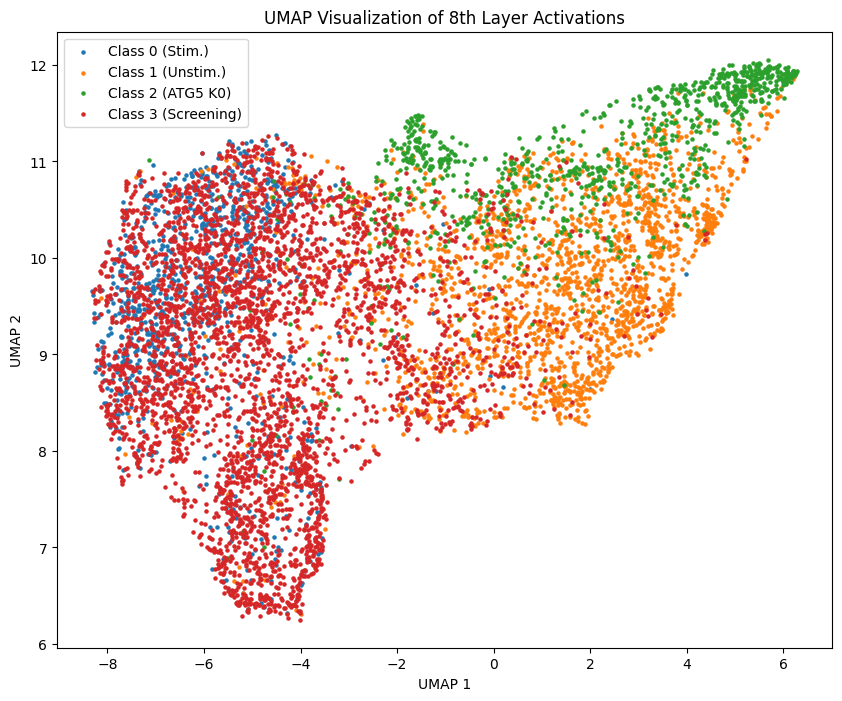

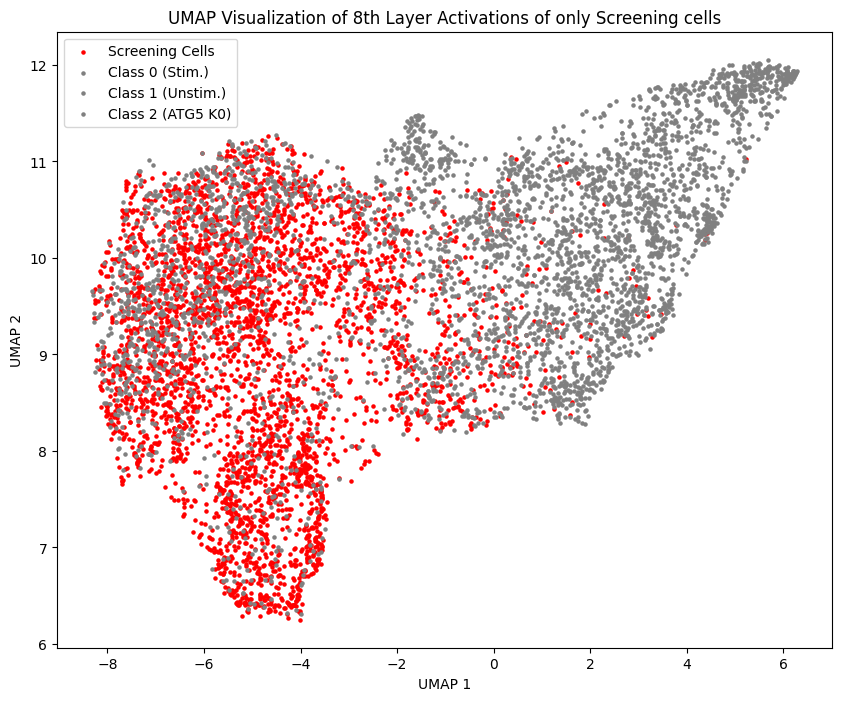

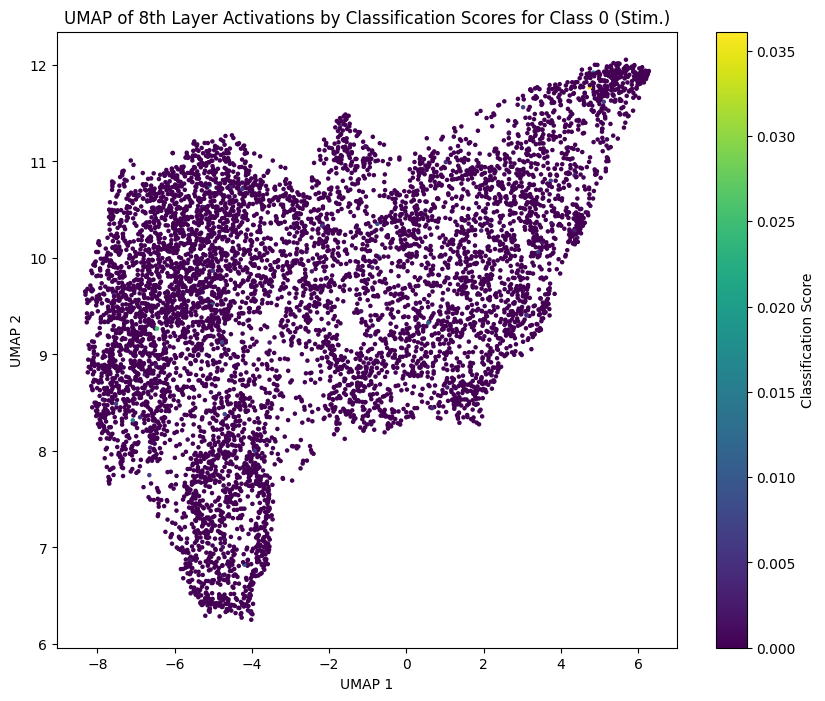

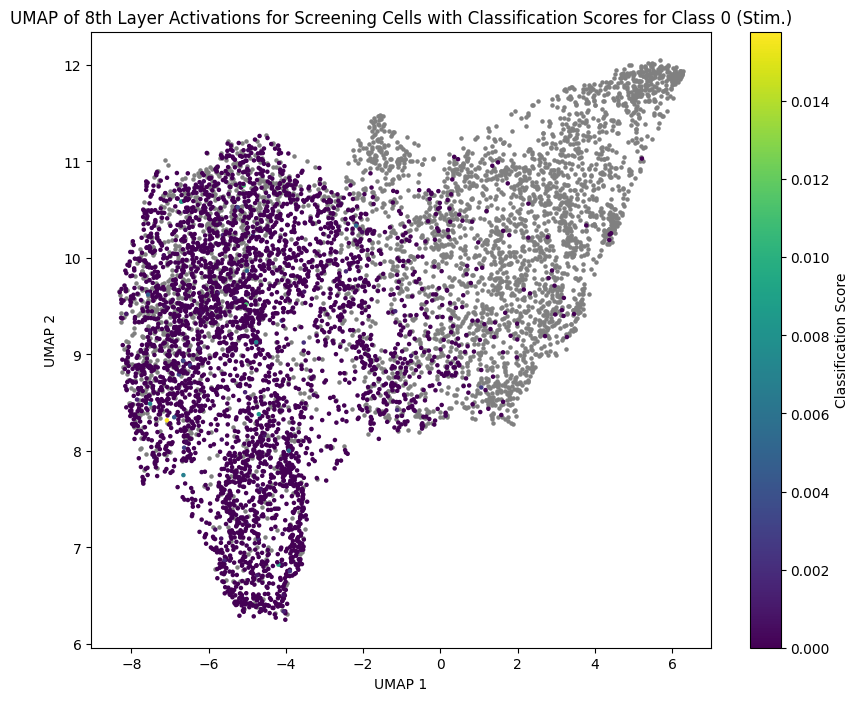

In [34]:
#Plotting UMAP using scatterplot instead of via scanpy
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)
plt.legend()
plt.title('UMAP Visualization of 8th Layer Activations')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot cells belonging to class 3 (screening) with red color
screening_idx = labels == 3
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], color='red', label='Screening Cells', s=5)

# Plot cells belonging to other classes in grey
for i, label in enumerate(class_labels[:-1]):  # Exclude the last class (screening)
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

plt.legend()
plt.title('UMAP Visualization of 8th Layer Activations of only Screening cells')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Determine the class index from the classification scores index
class_index = 0 
class_label = class_labels[class_index]
title = f'UMAP of 8th Layer Activations by Classification Scores for {class_label}'

# Plot UMAP with cells colored by classification score
plt.figure(figsize=(10, 8))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=classification_scores[:, class_index], cmap='viridis', s=5)
plt.colorbar(label='Classification Score')
plt.title(title)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show() 

class_index = 0
plt.figure(figsize=(10, 8))

# Plot cells belonging to class 3 (screening) with color based on classification score
for i, label in enumerate(class_labels[:-1]):  # Exclude the last class (screening)
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

# Color the screening cells based on their classification score
cmap = plt.get_cmap('viridis')
screening_scores = classification_scores[screening_idx]
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], c=screening_scores[:, class_index], cmap=cmap, label='Screening Cells', s=5)

# Add colorbar for classification scores
cbar = plt.colorbar()
cbar.set_label('Classification Score')

class_label = class_labels[class_index]
title = f'UMAP of 8th Layer Activations for Screening Cells with Classification Scores for {class_label}'

plt.title(title)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [21]:
#Save the adata
adata.write('Case1_5_adata.h5ad')

In [5]:
adata = sc.read_h5ad('Case1_5_adata.h5ad')